In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# Quick recap of Fourier transforms

We can express any periodic function as the sums of sines/cosines:

$$V(t) = \frac{a_0}{2} + \sum_{n=1}^{\infty}\left(a_n \cos(n\omega_0 t) + b_n\sin(n\omega_0 t)\right)$$

where $\omega_0=\frac{2\pi}{T}$, and $T$ is the period. We can easily solve for $a_n$'s and $b_n$'s:

$$a_n=\frac{2}{T}\int_{-T/2}^{T/2} V(t)\cos(n\omega_0) \mathrm{d}t$$

$$b_n=\frac{2}{T}\int_{-T/2}^{T/2} V(t)\sin(n\omega_0) \mathrm{d}t$$

We can also do this using complex exponentials (which can in turn be written as sines and cosines, if you like):

$$V(t) = \int_{n=-\infty}^{\infty}C_n \mathrm{e}^{j n \omega_0 t}$$

$$C_n = \frac{1}{T}\int_{-T/2}^{T/2} V(t) \mathrm{e}^{-j n \omega_0 t} \mathrm{d}t$$

In the limit of period going to infinity (so an arbitrary, well behaved function), we can write the series as an integral. This is known as a Fourier _transform_.

$$V(t) = \frac{1}{2\pi}\int_{n=-\infty}^{\infty}\tilde{V}(\omega) \mathrm{e}^{j\omega t}\mathrm{d}\omega$$

$$\tilde{V}(\omega) = \int_{n=-\infty}^{\infty} V(t) \mathrm{e}^{-j\omega t}\mathrm{d}t$$

At this point we see that the inverse of a Fourier transform is another Fourier transform. So any useful property we can identify between $t\rightarrow\omega$, will also apply in reverse, $\omega\rightarrow t$.

# Some practice

Let's look at these fourier series in motion. First I will make an array of time values to represent my $t$'s, and I will make a $V(t)$ function that is two periodic waves superimposed.

In [2]:
dt = 1e-6  # Sample every 1 microsecond
max_time = 1e-3  # take 1 ms of data
times = np.arange(-max_time / 2, (max_time + dt) / 2, dt)

omega0 = 2 * np.pi / (max_time - dt)  # Units of rad/s

amp1 = 1  # 1 Volt
omega1 = 5 * omega0
wave1 = amp1 * np.exp(1j * omega1 * times)

amp2 = 0.1  # 0.1 Volt
omega2 = 50 * omega0
wave2 = amp2 * np.exp(1j * omega2 * times)

Vt = wave1 + wave2

<IPython.core.display.Javascript object>


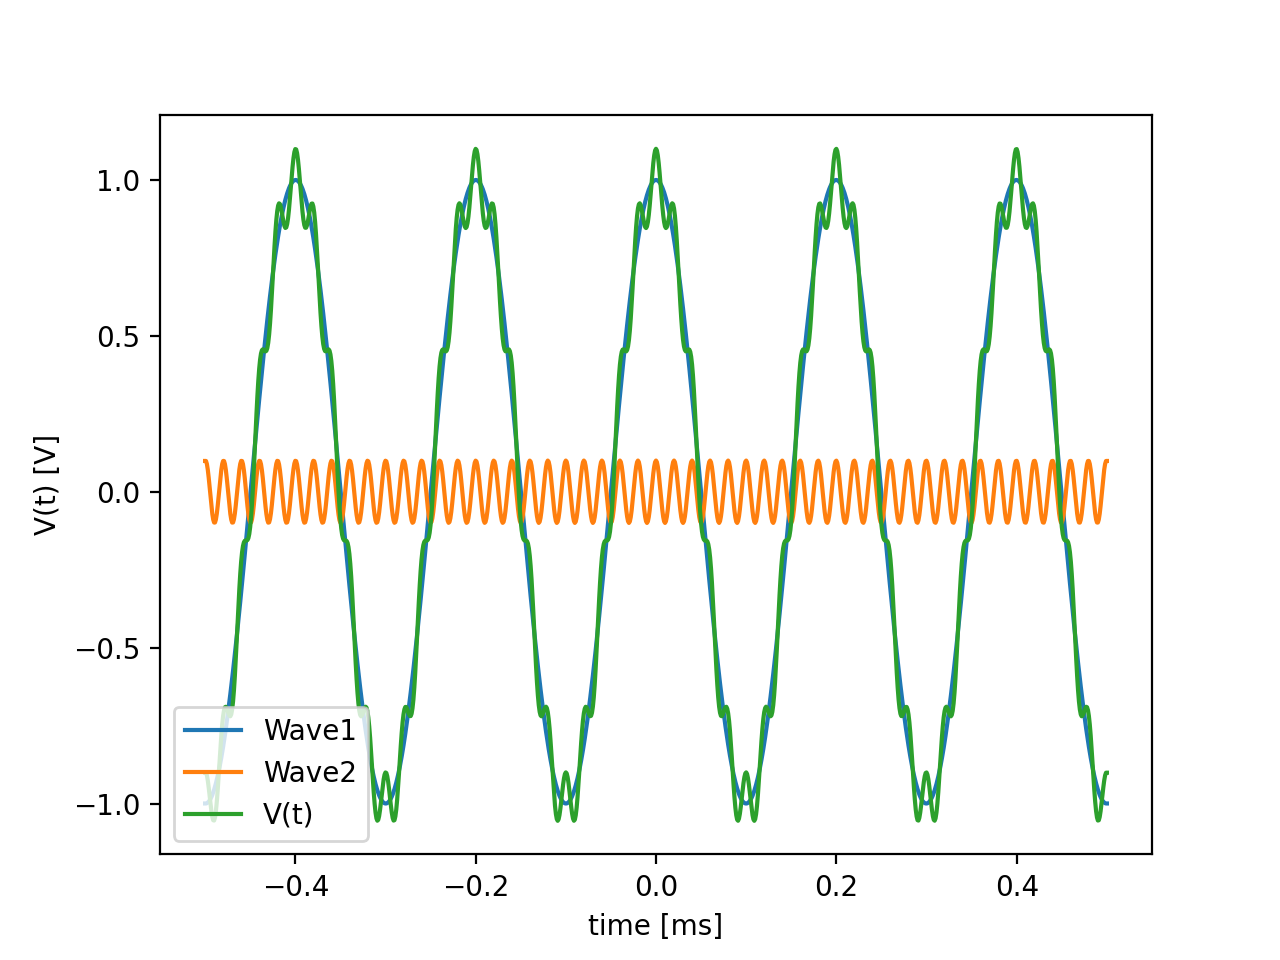

In [3]:
plt.figure('Waves added together')
plt.plot(times*1e3, np.real(wave1), label='Wave1')
plt.plot(times*1e3, np.real(wave2), label='Wave2')
plt.plot(times*1e3, np.real(Vt), label='V(t)')
plt.xlabel('time [ms]')
plt.ylabel('V(t) [V]')

plt.legend()

Next I will take the Fourier transform. Note that I can use the `np.fft.fftfreq()` function to create a frequency axis

In [4]:
Vf = np.fft.fft(np.fft.fftshift(Vt))
freqs = np.fft.fftfreq(len(times), dt)

<IPython.core.display.Javascript object>


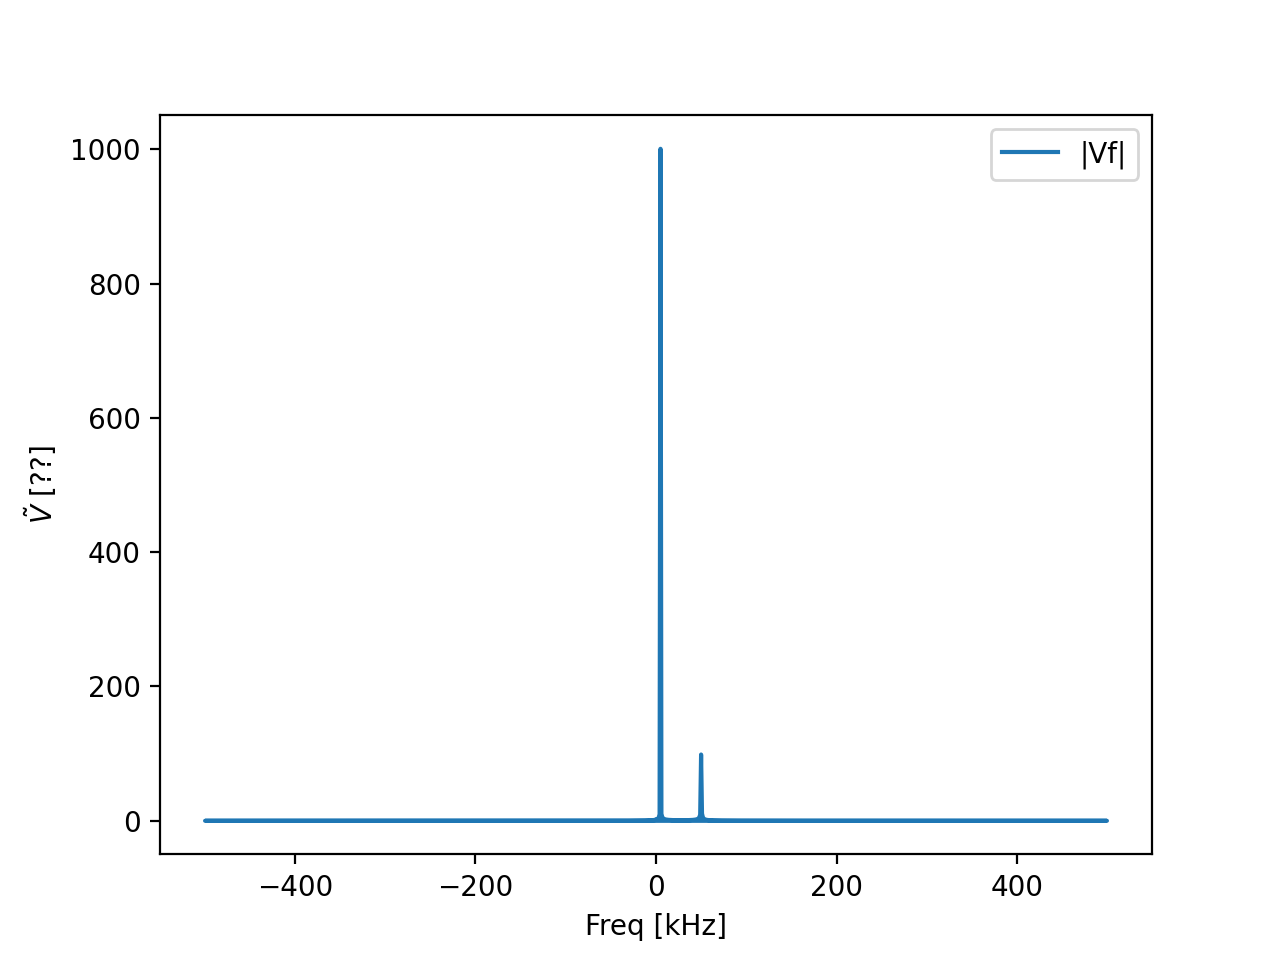

In [5]:
plt.figure('FT of two waves')

plt.plot(1e-3 * freqs, np.abs(Vf), label='|Vf|')
plt.xlabel('Freq [kHz]')
plt.ylabel(r'$\tilde{V}$ [??]')
plt.legend()

**NOTE**: The frequencies provided by `np.fft.fftfreq` are cycles per unit time ($f$), *not* rad per unit time ($\omega$). We can easily rewrite our Fourier transform relationship with a variable substitution. I suggest giving this a try on your own if you aren't comfortable with it.

$$V(t)=\int_{-\infty}^{\infty}\tilde{V}(f)\mathrm{e}^{2\pi j f t}\mathrm{d}f\newline
\tilde{V}(f)=\int_{-\infty}^{\infty}V(t)\mathrm{e}^{-2\pi j f t}\mathrm{d}t $$

A couple questions to answer:
- Why did we have to do `np.fft.fftshift`?
- What are the units on the verical axis?

We can answer both of these by looking at how numpy calculates the fourier transform. Numpy (and any numerical package) calculates the *discrete Fourier transform* (DFT). There are different conventions, so you may have to look up your specific analysis package. The details here are for numpy. The actual calculation that numpy does is:

$$ A_k = \sum_{m=0}^{n-1}a_m\mathrm{e}^{-2\pi j m k/n},\,\, k=0, 1, ..., n-1$$

This looks *like* our integral for $\tilde{V}(f)$, but not quite. If we make a couple substitutions we can see how it looks closer. First, we see we are evaluating for $k=0, 1, ..., n-1$. If we observe that the frequency spacing should be $\Delta f = \frac{\Delta \omega}{2\pi} = 1/T$, we see that $f = k\Delta f=k / T$. This is essentially the calculation the `np.fft.fftfreq` is doing for you.

Next, what is $m$? $m$ is the index we are summing over, but really we want to integrate over time. So we make the connection $t = m \Delta t$. But notice that our data started at $t=-T/2$, and $m$ starts at 0. **This is why we shift**. The `np.fft.fftshift` function shifts the data to put $t=0$ at the first data entry.

Ok, with the substitutions for $k$ and $m$, our sum looks a lot like a rectangle approximation of an integral. The only missing piece is the width of the rectangle, $\mathrm{d}t$. If we truly want to get our units right, we must multiply the result of the FFT by $\Delta t$. Only then will we be properly approximating our integral, and **have the appropriate units of V$\,$s**.

## Some properties to notice

### Frequency resolution

We saw the frequency spacing, $\Delta \omega = \omega_0 = \frac{2\pi}{T}$, was inversely proportional to the period. In other words, the longer it takes for the function to repeat, the finer frequencies are "resolved." Let's investigate that some more.

In [6]:
dt = 1e-6  # Sample every 1 microsecond
max_time = 1e-3  # take 1 ms of data
times = np.arange(-max_time / 2, (max_time + dt) / 2, dt)

omega0 = 2 * np.pi / (max_time - dt)

amp1 = 1  # 1 Volt
omega1 = 5 * omega0  # 10 rad/s
wave1 = amp1 * np.exp(1j * omega1 * times)

amp2 = 1  # 0.1 Volt
omega2 = omega1 + 0.5 * omega0
wave2 = amp2 * np.exp(1j * omega2 * times)

Vt = wave1 + wave2

Vf = np.fft.fft(np.fft.fftshift(Vt)) * dt
freqs = np.fft.fftfreq(len(times), dt)

<IPython.core.display.Javascript object>


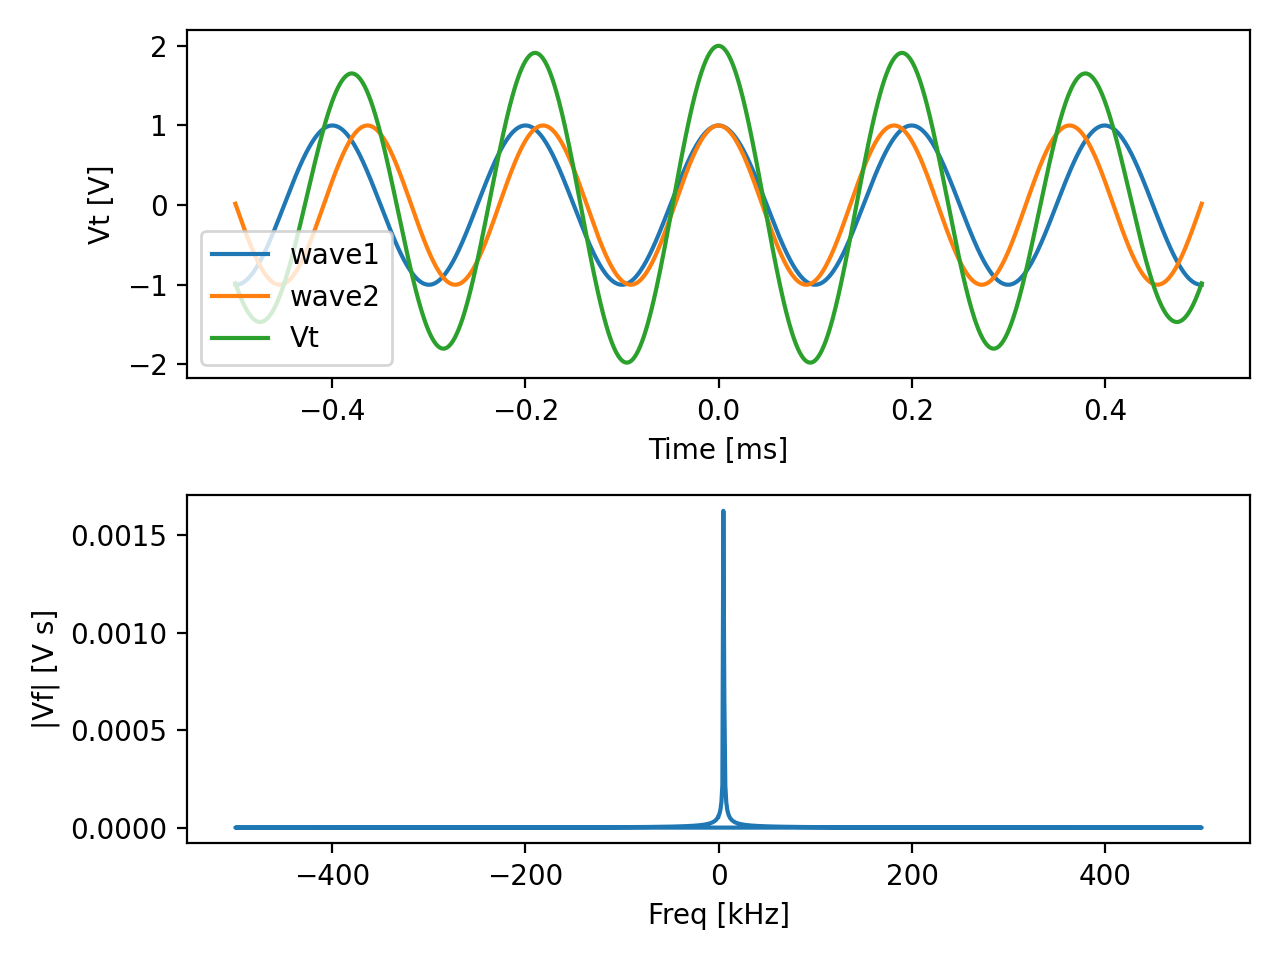

In [7]:
plt.figure('Unresolved Frequencies')
plt.subplot(211)

plt.plot(times*1e3, np.real(wave1),label='wave1')
plt.plot(times*1e3, np.real(wave2),label='wave2')
plt.plot(times*1e3, np.real(Vt),label='Vt')
plt.xlabel('Time [ms]')
plt.ylabel('Vt [V]')
plt.legend()

plt.subplot(212)
plt.plot(freqs*1e-3, np.abs(Vf))
plt.xlabel('Freq [kHz]')
plt.ylabel('|Vf| [V s]')

plt.tight_layout()

In [8]:
dt = 1e-6  # Sample every 1 microsecond
max_time2 = 5 * 1e-3  # take 5 ms of data
times = np.arange(-max_time2 / 2, (max_time2 + dt) / 2, dt)

# omega0 = 2 * np.pi / (max_time - dt)
# Do NOT update omega0 - we are comparing to the same frequencies above

amp1 = 1  # 1 Volt
omega1 = 5 * omega0  # 10 rad/s
wave1 = amp1 * np.exp(1j * omega1 * times)

amp2 = 1  # 0.1 Volt
omega2 = omega1 + 0.5 * omega0
wave2 = amp2 * np.exp(1j * omega2 * times)

Vt = wave1 + wave2

Vf = np.fft.fft(np.fft.fftshift(Vt)) * dt
freqs = np.fft.fftfreq(len(times), dt)

<IPython.core.display.Javascript object>


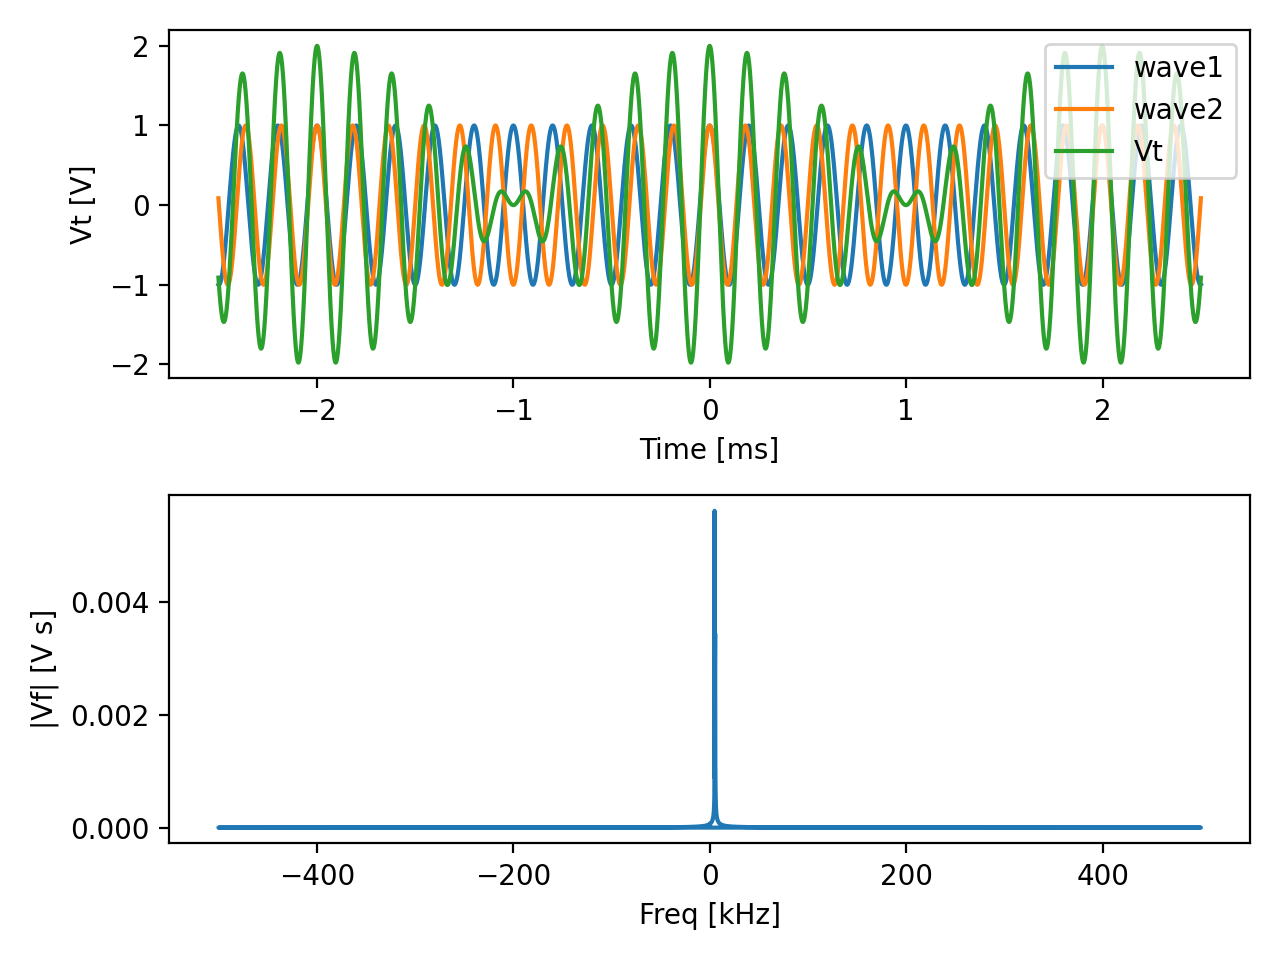

In [9]:
plt.figure('Longer time sampling')
plt.subplot(211)

plt.plot(times*1e3, np.real(wave1), label='wave1')
plt.plot(times*1e3, np.real(wave2), label='wave2')
plt.plot(times*1e3, np.real(Vt), label='Vt')
plt.xlabel('Time [ms]')
plt.ylabel('Vt [V]')
plt.legend()

plt.subplot(212)
plt.plot(1e-3 * freqs, np.abs(Vf))
plt.xlabel('Freq [kHz]')
plt.ylabel('|Vf| [V s]')

plt.tight_layout()

With enough time, we can observe periods of constructive _and_ destructive interference, and ultimately can resolve the different frequencies.

### Maximum Frequency



In [10]:
dt = 1e-6  # Sample every 1 microsecond
max_time = 1e-3  # take 1 ms of data
times = np.arange(-max_time / 2, (max_time + dt) / 2, dt)

omega0 = 2 * np.pi / (max_time - dt)

amp1 = 1  # 1 Volt
omega1 = (len(times) + 1) * omega0  ## Too large of a frequency
wave1 = amp1 * np.exp(1j * omega1 * times)

Vt = wave1

Vf = np.fft.fft(np.fft.fftshift(Vt)) * dt
freqs = np.fft.fftfreq(len(times), dt)

<IPython.core.display.Javascript object>


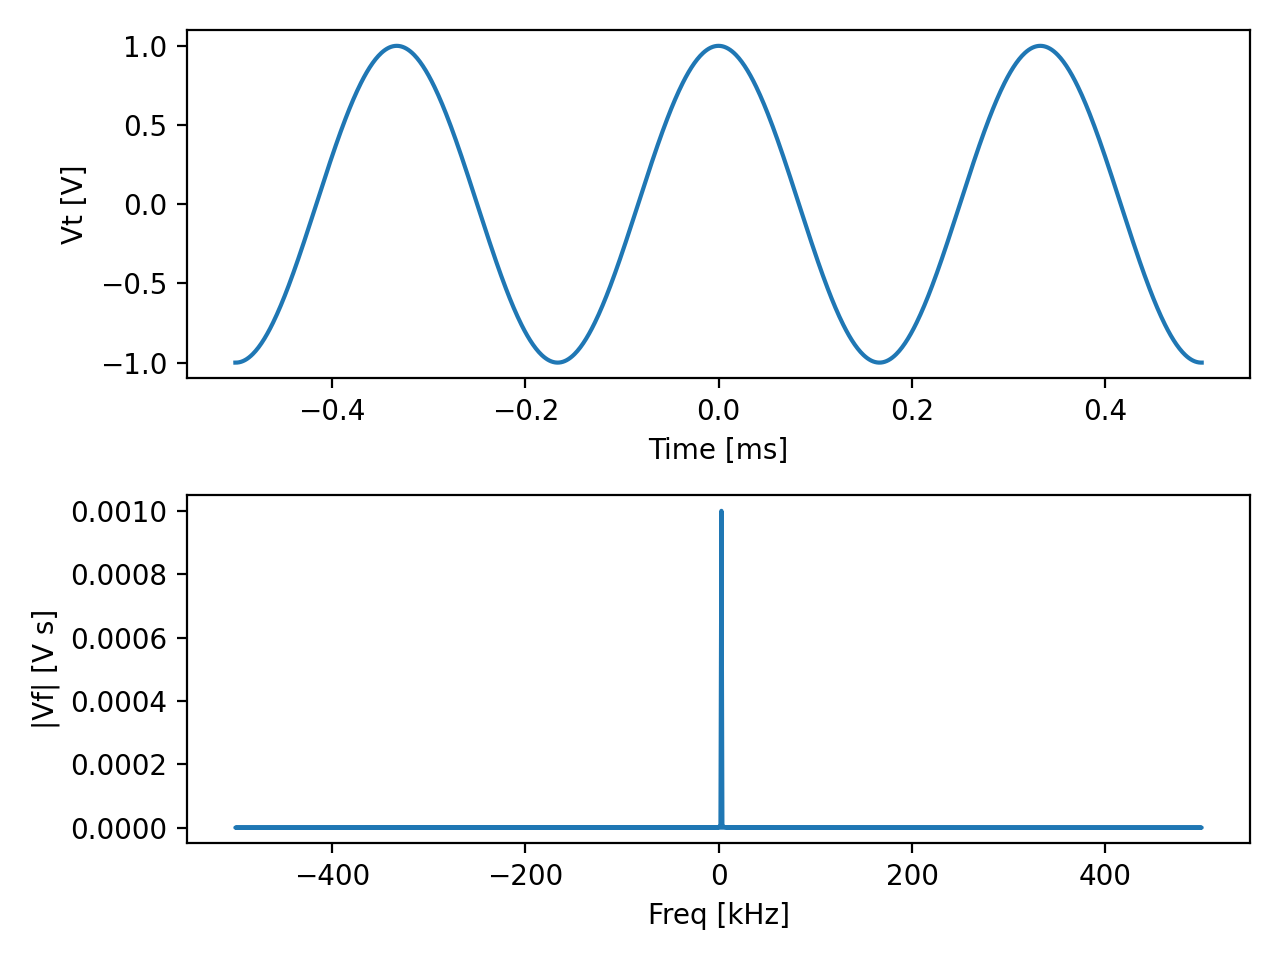

In [11]:
plt.figure('Under sampled wave')
plt.subplot(211)

plt.plot(times*1e3, np.real(Vt),label='Vt')
plt.xlabel('Time [ms]')
plt.ylabel('Vt [V]')

plt.subplot(212)
plt.plot(1e-3 * freqs, np.abs(Vf))
plt.xlabel('Freq [kHz]')
plt.ylabel('|Vf| [V s]')

plt.tight_layout()

In [12]:
dt = 1e-7  # Sample every .1 microsecond
max_time = 1e-3  # take 1 ms of data
times_fine = np.arange(-max_time / 2, (max_time + dt) / 2, dt)

omega0 = 2 * np.pi / (max_time - dt)

amp1 = 1  # 1 Volt
#omega1 = (len(times) + 1) * omega0  ## Too large of a frequency
# Dont change frequency
wave1 = amp1 * np.exp(1j * omega1 * times_fine)

Vt_fine = wave1

Vf_fine = np.fft.fft(np.fft.fftshift(Vt_fine)) * dt
freqs_fine = np.fft.fftfreq(len(times_fine), dt)

<IPython.core.display.Javascript object>


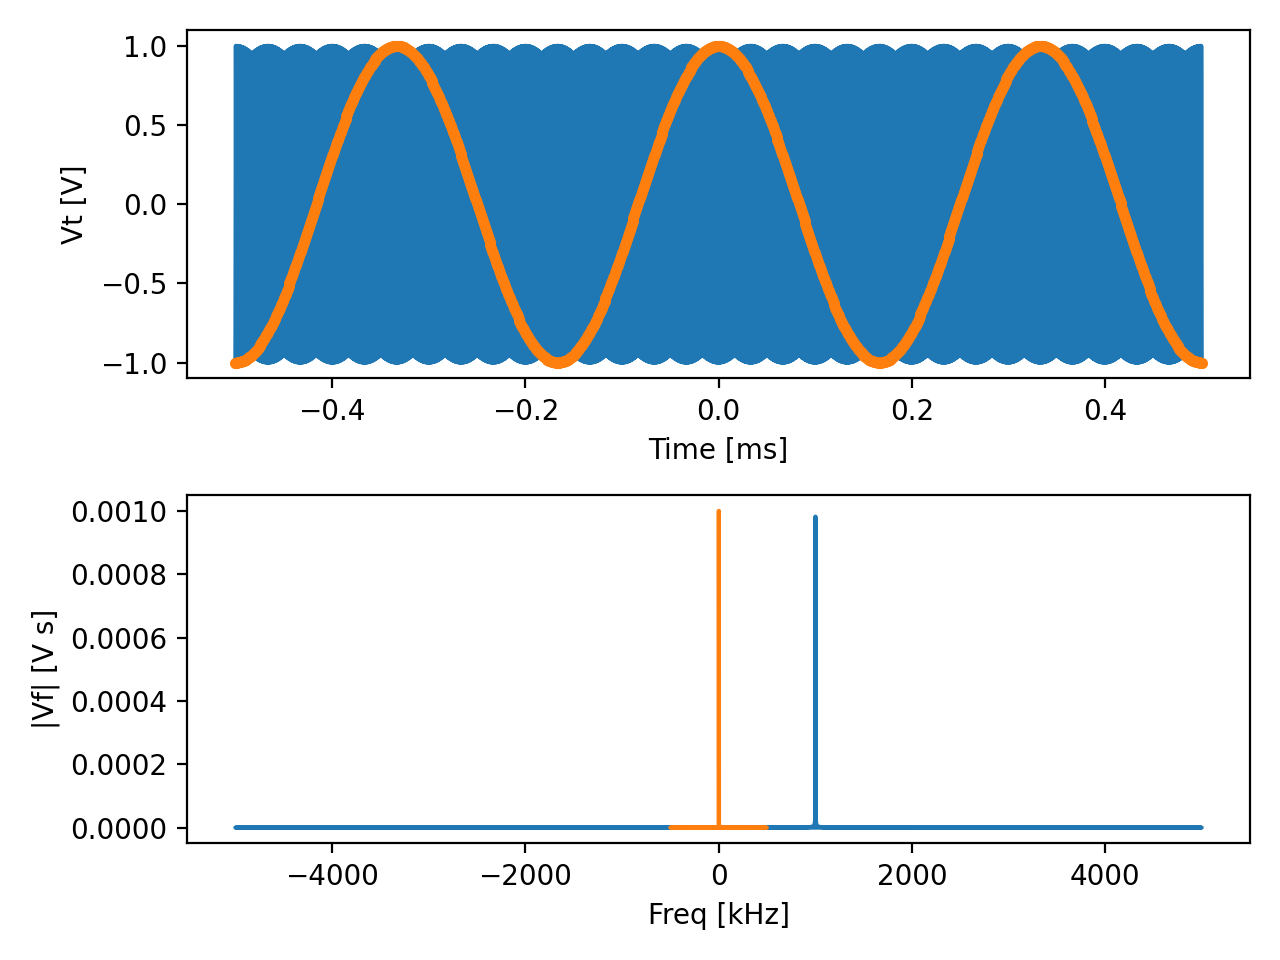

In [13]:
plt.figure('Aliasing')
plt.subplot(211)

plt.plot(times_fine*1e3, np.real(Vt_fine), label='Vt_fine')
plt.plot(times*1e3, np.real(Vt), '.', label='Vt')
plt.xlabel('Time [ms]')
plt.ylabel('Vt [V]')

plt.subplot(212)
plt.plot(1e-3 * freqs_fine, np.abs(Vf_fine))
plt.plot(1e-3 * freqs, np.abs(Vf))
plt.xlabel('Freq [kHz]')
plt.ylabel('|Vf| [V s]')

plt.tight_layout()

By not sampling time fast enough, we do not capture the waveform. This can result in a "beading" effect very similar to listening to tuning forks that have slightly different pitches. In spectral analysis, we call this *aliasing* because a wave at one frequency is aliased to another frequency. This can be very dangerous, so watch out for it!

You will also see this in the context of the *Nyquist frequency*. The Nyquist frequency is the highest frequency that you can resolve at a given sampling rate, and it is equal to half the sampling rate. In other words, to resolve a signal at frequency $f_s$, you must sample at least the Nyquist frequency for that signal: $f_{sample}\ge f_{Nyquist} = 2f_s$.